In [33]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
articledf = pd.read_csv('../data/article_preprocessed.csv')

In [35]:
w2v_model = Word2Vec.load('../models/word2vec_fake_news.model')

In [36]:
texts = articledf['tokens'].tolist()
labels = articledf['target'].values

In [37]:
# Create word-index mapping (start from 1, reserve 0 for padding)
word_index = {word: i + 1 for i, word in enumerate(w2v_model.wv.index_to_key)}
vocab_size = len(word_index) + 1  # +1 for padding

# Convert text to sequence of indices
def tokens_to_indices(tokens):
    return [word_index.get(token, 0) for token in tokens]

sequences = [tokens_to_indices(tokens) for tokens in texts]

# Pad sequences
max_len = 300  # You can also compute 95th percentile of sequence lengths
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = labels

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
X_train.shape, X_test.shape

((33673, 300), (11225, 300))

In [40]:
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

## Using LSTM

In [41]:
# Define the model_lstm
model_lstm = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),  # Freeze Word2Vec
    LSTM(128, return_sequences=False),  # LSTM instead of GRU
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model_lstm
model_lstm.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_lstm.summary()

/Users/adityagoyal/SRH/Advanced Programming/fakenews/venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    12,826,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,826,300 (48.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,826,300 (48.93 MB)

In [42]:
with tf.device('/GPU:0'):
    history_lstm = model_lstm.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=10,
        batch_size=128,
        # callbacks=[tensorboard_cb],
        verbose=1
    )

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 309ms/step - accuracy: 0.8594 - loss: 0.3548 - val_accuracy: 0.9195 - val_loss: 0.2302
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 329ms/step - accuracy: 0.9372 - loss: 0.1991 - val_accuracy: 0.9388 - val_loss: 0.1877
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 340ms/step - accuracy: 0.9445 - loss: 0.1761 - val_accuracy: 0.9445 - val_loss: 0.1800
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 346ms/step - accuracy: 0.9450 - loss: 0.1731 - val_accuracy: 0.9308 - val_loss: 0.2032
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 348ms/step - accuracy: 0.9363 - loss: 0.1978 - val_accuracy: 0.9305 - val_loss: 0.2031
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 85s 360ms/step - accuracy: 0.9434 - loss: 0.1800 - val_accuracy: 0.9350 - val_loss: 0.1915
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 350ms/step - accuracy: 0.9463 - loss: 0.1657 - val_accuracy: 0.9469 - val_loss: 0.1629
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 85s 358ms/step - accuracy: 0.9500 - loss: 0

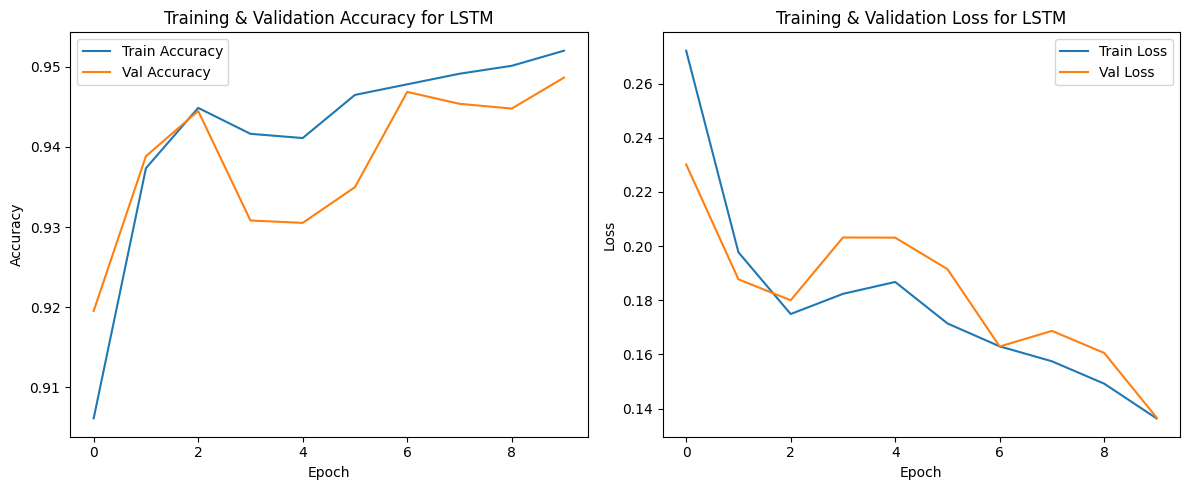

In [43]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9508 - loss: 0.1385
Test Accuracy: 0.9514


351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step


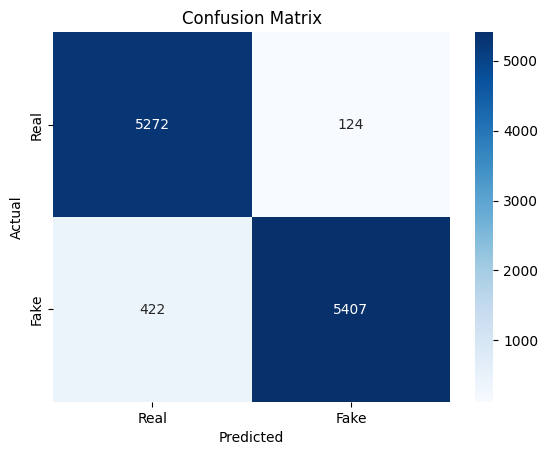

              precision    recall  f1-score   support

        Real       0.93      0.98      0.95      5396
        Fake       0.98      0.93      0.95      5829

    accuracy                           0.95     11225
   macro avg       0.95      0.95      0.95     11225
weighted avg       0.95      0.95      0.95     11225



In [45]:
# Predict on test set
y_pred = (model_lstm.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

In [46]:
model_lstm.save("../models/lstm_fake_news_model.keras")
model_lstm.save_weights("../models/lstm_fake_news.weights.h5")

## Using GRU

In [47]:
model_gru = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),  # freeze embeddings
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_gru.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_gru.summary()

/Users/adityagoyal/SRH/Advanced Programming/fakenews/venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │    12,826,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,826,300 (48.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,826,300 (48.93 MB)

In [48]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [49]:
with tf.device('/GPU:0'):
    history_gru = model_gru.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=10,
        batch_size=128,
        verbose=1,
        # callbacks=[tensorboard_cb]
    )

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 112s 467ms/step - accuracy: 0.8561 - loss: 0.3539 - val_accuracy: 0.9323 - val_loss: 0.2120
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 107s 451ms/step - accuracy: 0.9375 - loss: 0.2040 - val_accuracy: 0.9341 - val_loss: 0.1999
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 120s 506ms/step - accuracy: 0.9418 - loss: 0.1871 - val_accuracy: 0.9317 - val_loss: 0.2095
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 110s 464ms/step - accuracy: 0.9409 - loss: 0.1914 - val_accuracy: 0.9415 - val_loss: 0.1831
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 118s 497ms/step - accuracy: 0.9452 - loss: 0.1774 - val_accuracy: 0.9415 - val_loss: 0.1754
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 116s 490ms/step - accuracy: 0.9481 - loss: 0.1628 - val_accuracy: 0.9469 - val_loss: 0.1653
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 117s 494ms/step - accuracy: 0.9510 - loss: 0.1404 - val_accuracy: 0.9543 - val_loss: 0.1319
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 111s 468ms/step - accuracy: 0.9554 -

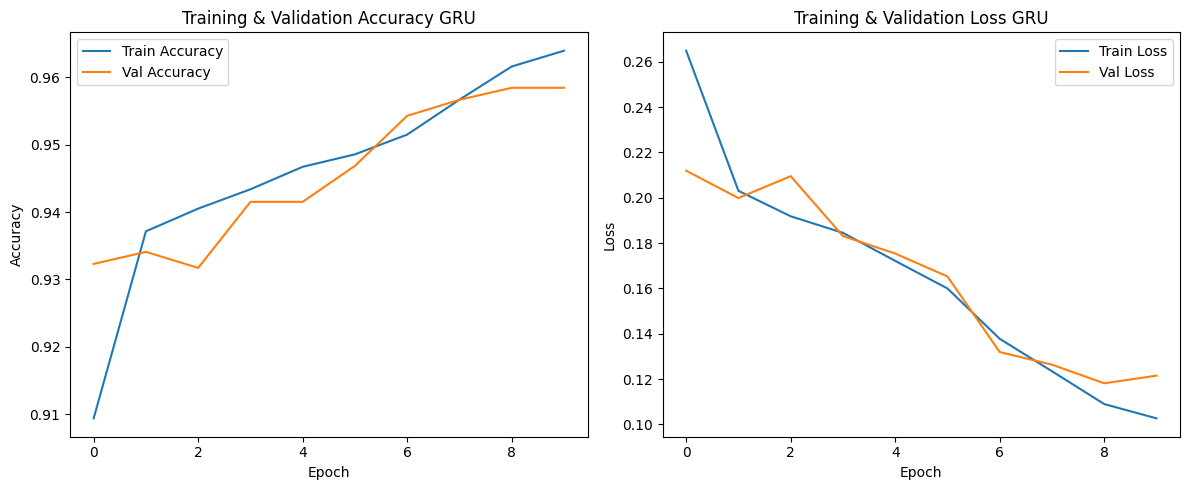

In [50]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy GRU')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
loss, accuracy = model_gru.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9577 - loss: 0.1179
Test Accuracy: 0.9580


351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step


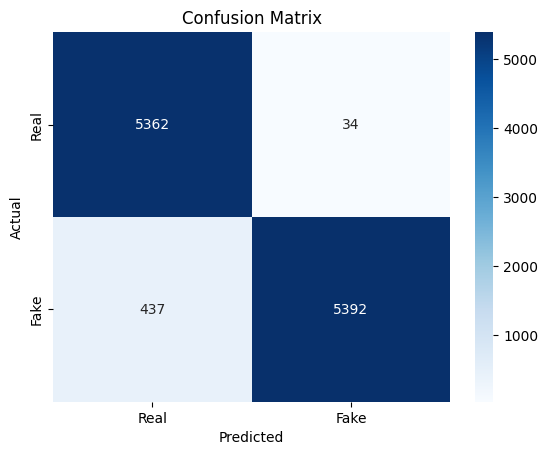

              precision    recall  f1-score   support

        Real       0.92      0.99      0.96      5396
        Fake       0.99      0.93      0.96      5829

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225



In [52]:
# Predict on test set
y_pred = (model_gru.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

In [53]:
model_gru.save("../models/gru_fake_news_model.keras")
model_gru.save_weights("../models/gru_fake_news.weights.h5")

In [54]:
# !kill 17566